<h1>Isolate live CD3+ single cells from drain fluid</h1>

In [1]:
import sys
sys.path.append("/home/ross/CytoPy")

In [2]:
from CytoPy.data.project import Project
from CytoPy.data.setup import global_init
from CytoPy.data.gating_strategy import *
from CytoPy.flow import variance
global_init("Peritonitis")

In [3]:
import seaborn as sns
sns.set(style="white", font_scale=1.2)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [4]:
peritonitis_project = Project.objects(project_id="Immunofingerprints").get()
exp = peritonitis_project.load_experiment("Drain fluid T cells")

<h2>Generate gating strategy</h2>

In [6]:
gates = GatingStrategy(name="T cell gating")

In [6]:
features = ['FSC-A', 'SSC-A', 'CXCR3', 'CD161',
           'CCR7', 'Va7-2', 'CD8', 'Vd2', 'CD45RA', 
            'PanGD', 'CD4', 'CD27']
variance.calculate_ref_sample(variance.load_and_sample(experiment=exp,
                                                       population="root",
                                                       sample_size=10000,
                                                       features=features)[0],
                              features=features)

  0%|          | 0/46 [00:00<?, ?it/s]

Calculate covariance matrix for each sample...
Search for sample with smallest average euclidean distance to all other samples...


'288-02'

In [7]:
gates.load_data(exp, "288-02")

<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

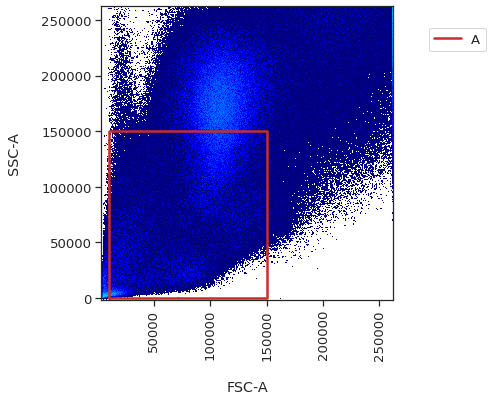

In [8]:
cell_gate = PolygonGate(gate_name="cell_gate",
                        parent="root",
                        x="FSC-A",
                        y="SSC-A",
                        transform_x=None,
                        transform_y=None,
                        method="manual",
                        method_kwargs={"x_values": [10000, 150000, 150000, 10000, 10000],
                                       "y_values": [0, 0, 150000, 150000, 0]})
gates.preview_gate(cell_gate)

In [9]:
cell_gate.label_children({"A": "Cells"})
gates.apply_gate(cell_gate, plot=False)

----- cell_gate -----
Parent (root) n: 4021928
...child Cells n: 1266101; 31.479951903664112% of parent
------------------------


<AxesSubplot:xlabel='CD3'>

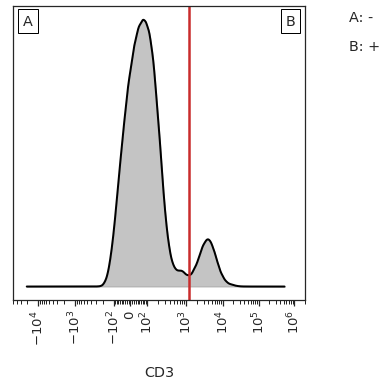

In [10]:
cd3_gate = ThresholdGate(gate_name="cd3_gate",
                         parent="Cells",
                         x="CD3",
                         transform_x="logicle",
                         method="density")
gates.preview_gate(cd3_gate)

In [11]:
cd3_gate.label_children({"+": "CD3+", "-": "CD3-"})
gates.apply_gate(cd3_gate, plot=False)

----- cd3_gate -----
Parent (Cells) n: 1266101
...child CD3+ n: 113905; 8.996517655384523% of parent
...child CD3- n: 1152196; 91.00348234461548% of parent
------------------------


In [12]:
gates.add_normalisation("cd3_gate")
gates.add_hyperparameter_grid("cd3_gate",
                              {"min_peak_threshold": [0.01, 0.05, 0.1],
                               "peak_boundary": [0.1, 0.25, 0.4]})

<AxesSubplot:xlabel='LD'>

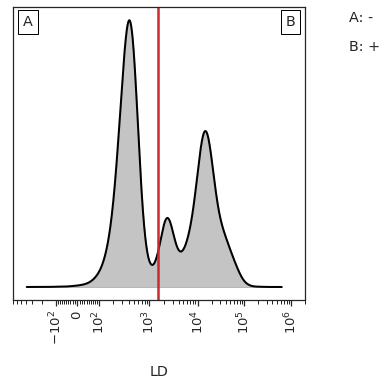

In [13]:
live_gate = ThresholdGate(gate_name="live_gate",
                          parent="CD3+",
                          x="LD",
                          transform_x="logicle",
                          method="density")
gates.preview_gate(live_gate)

In [14]:
live_gate.label_children({"+": "Dead",
                          "-": "Live CD3+"})
gates.apply_gate(live_gate, plot=False)

----- live_gate -----
Parent (CD3+) n: 113905
...child Dead n: 53288; 46.78284535358413% of parent
...child Live CD3+ n: 60617; 53.21715464641588% of parent
------------------------


In [15]:
gates.add_normalisation("live_gate")
gates.add_hyperparameter_grid("live_gate",
                              {"min_peak_threshold": [0.01, 0.05, 0.1],
                               "peak_boundary": [0.1, 0.25, 0.4]})

<AxesSubplot:xlabel='FSC-A', ylabel='FSC-H'>

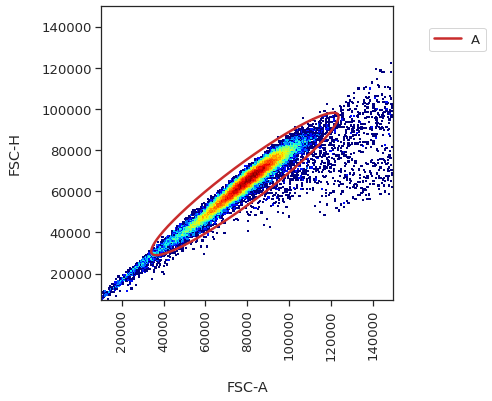

In [16]:
singlets = EllipseGate(gate_name="singlets_gate",
                        parent="Live CD3+",
                        x="FSC-A",
                        y="FSC-H",
                        transform_x=None,
                        transform_y=None,
                        method="GaussianMixture",
                        method_kwargs={"n_components": 1, "conf": 0.99})
gates.preview_gate(singlets)

In [17]:
singlets.label_children({"A": "Single Live CD3+"})
gates.apply_gate(singlets, plot=False)

----- singlets_gate -----
Parent (Live CD3+) n: 60617
...child Single Live CD3+ n: 58781; 96.9711467080192% of parent
------------------------


In [18]:
gates.add_normalisation("singlets_gate")
gates.add_hyperparameter_grid("singlets_gate",
                              {"n_components": [1, 2, 3]})

<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

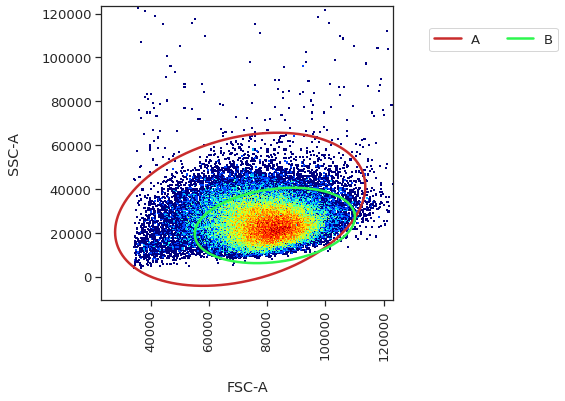

In [19]:
tcell_gate = EllipseGate(gate_name="tcell_gate",
                         parent="Single Live CD3+",
                         x="FSC-A",
                         y="SSC-A",
                         transform_x=None,
                         transform_y=None,
                         method="GaussianMixture",
                         method_kwargs={"n_components": 2, "conf": 0.99})
gates.preview_gate(tcell_gate)

In [20]:
tcell_gate.label_children({"B": "T cells"})
gates.apply_gate(tcell_gate, plot=False)

----- tcell_gate -----
Parent (Single Live CD3+) n: 58781
...child T cells n: 51380; 87.40919684932206% of parent
------------------------


In [21]:
gates.add_normalisation("tcell_gate")
gates.add_hyperparameter_grid("tcell_gate",
                              {"n_components": [1, 2, 3]})

In [22]:
gates.save()

<h2>Apply to experiment material</h2>

In [23]:
gates.apply_to_experiment(exp, 
                          logging_path="tcell_gatting.log", 
                          fda_norm=True, 
                          hyperparam_search=True)

  0%|          | 0/46 [00:00<?, ?it/s]

/home/ross/CytoPy/CytoPy/flow/fda_norm.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p, plabels = np.array(p), np.array(plabels)
/home/ross/CytoPy/CytoPy/flow/fda_norm.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p, plabels = np.array(p), np.array(plabels)
/home/ross/CytoPy/CytoPy/flow/fda_norm.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object'

<h3>Addressing issues from logs</h3>

<h4>142-09</h4>

In [29]:
gates.load_data(exp, "142-09")

In [30]:
gates.print_population_tree()

root
└── Cells
    ├── CD3+
    │   ├── Dead
    │   └── Live CD3+
    └── CD3-


<AxesSubplot:xlabel='CD3', ylabel='LD'>

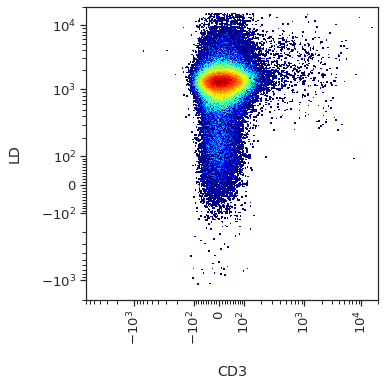

In [31]:
gates.plot_population("Cells", "CD3", "LD", transform_x="logicle", transform_y="logicle")

In [32]:
exp.remove_sample("142-09")

<h4>210-14</h4>

In [16]:
gates.load_data(exp, "210-14")
gates.print_population_tree()

root


<AxesSubplot:xlabel='CD3', ylabel='LD'>

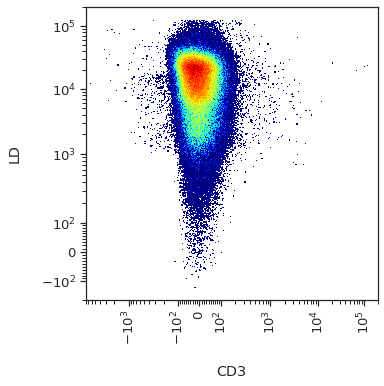

In [19]:
gates.plot_population("Cells", "CD3", "LD", transform_x="logicle", transform_y="logicle")

In [20]:
exp.remove_sample("210-14")

<h1>Isolate CD45+ cells from drain fluid</h1>

In [5]:
exp = peritonitis_project.load_experiment("Drain fluid Leukocytes")

In [39]:
exp.panel.list_markers()

['',
 '',
 '',
 '',
 '',
 '',
 '',
 'CD14',
 'CD16',
 'Siglec8',
 'CD45',
 'CD3',
 'CD1c',
 'LD',
 'CD15',
 'HLA-DR',
 'CD116',
 'CD19']

<h2>Generate gating strategy</h2>

In [42]:
gates = GatingStrategy(name="CD45+ gate")

In [9]:
features = ['FSC-A', 'SSC-A',  'CD14',
            'CD16', 'Siglec8', 'CD45',
            'CD3', 'CD1c', 'LD',
            'CD15', 'HLA-DR', 'CD116',
            'CD19']
variance.calculate_ref_sample(variance.load_and_sample(experiment=exp,
                                                       population="root",
                                                       sample_size=10000,
                                                       features=features)[0],
                              features=features)

  0%|          | 0/47 [00:00<?, ?it/s]

Calculate covariance matrix for each sample...
Search for sample with smallest average euclidean distance to all other samples...


'288-02'

In [43]:
gates.load_data(exp, "288-02")

<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

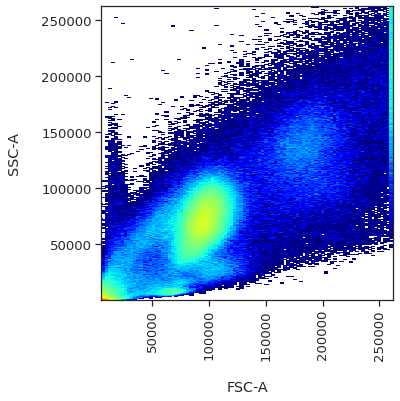

In [44]:
gates.plot_population("root", "FSC-A", "SSC-A", 
                      transform_x=None, transform_y=None,
                      create_plot_kwargs={"autoscale": False,
                                          "bins": 2000})

<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

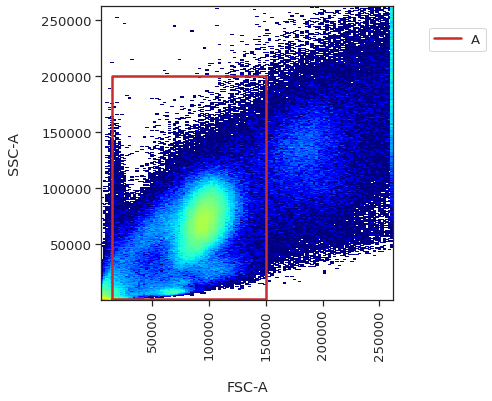

In [45]:
cell_gate = PolygonGate(gate_name="cell_gate",
                        parent="root",
                        x="FSC-A",
                        y="SSC-A",
                        transform_x=None,
                        transform_y=None,
                        method="manual",
                        method_kwargs={"x_values": [15000, 150000, 150000, 15000, 15000],
                                       "y_values": [1000, 1000, 200000, 200000, 1000]})
gates.preview_gate(cell_gate, create_plot_kwargs={"autoscale": False, "bins": 2500})

In [46]:
cell_gate.label_children({"A": "Cells"})
gates.apply_gate(cell_gate, plot=False)

----- cell_gate -----
Parent (root) n: 1878606
...child Cells n: 1520146; 80.91883023901765% of parent
------------------------


<AxesSubplot:xlabel='CD45', ylabel='LD'>

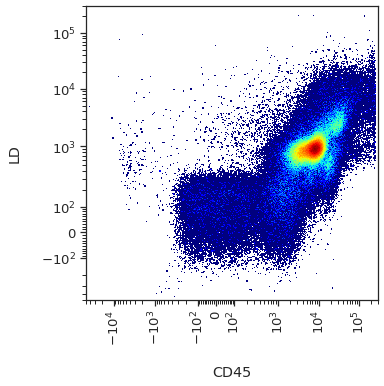

In [47]:
gates.plot_population("Cells", "CD45", "LD", transform_x="logicle", transform_y="logicle")

<AxesSubplot:xlabel='CD45', ylabel='LD'>

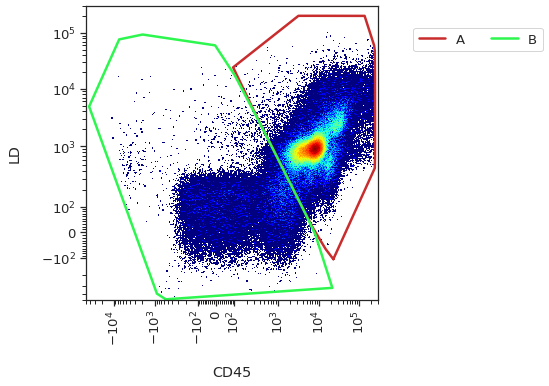

In [48]:
cd45_gate = PolygonGate(gate_name="CD45 Gate",
                        parent="Cells",
                        x="CD45",
                        y="LD", 
                        transform_x="logicle",
                        transform_y="logicle",
                        method="MiniBatchKMeans",
                        method_kwargs={"n_clusters": 2, 
                                       "batch_size": 1000,
                                       "random_state": 42})
gates.preview_gate(cd45_gate)

In [49]:
cd45_gate.label_children({"A": "CD45+ cells"})
gates.apply_gate(cd45_gate, plot=False)

----- CD45 Gate -----
Parent (Cells) n: 1520146
...child CD45+ cells n: 1441795; 94.84582401953496% of parent
------------------------


<AxesSubplot:xlabel='LD'>

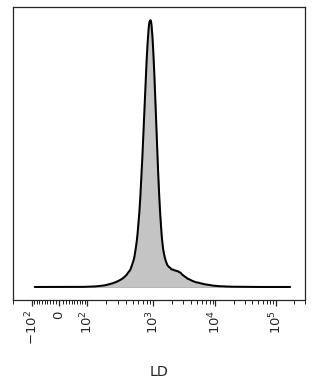

In [50]:
gates.plot_population("CD45+ cells", "LD", transform_x="logicle")

<AxesSubplot:xlabel='LD'>

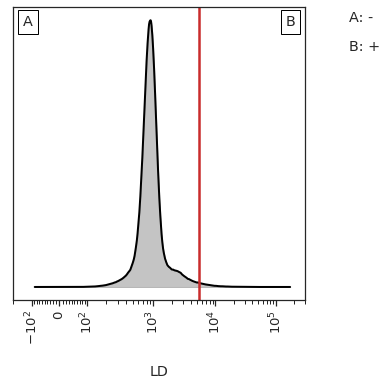

In [51]:
live_gate = ThresholdGate(gate_name="live_gate",
                          parent="CD45+ cells",
                          x="LD",
                          transform_x="logicle",
                          method="quantile",
                          method_kwargs={"q": 0.99})
gates.preview_gate(live_gate)

----- live_gate -----
Parent (CD45+ cells) n: 1441795
...child Dead n: 14418; 1.0000034678993894% of parent
...child Live CD45+ cells n: 1427377; 98.99999653210061% of parent
------------------------


<AxesSubplot:xlabel='LD'>

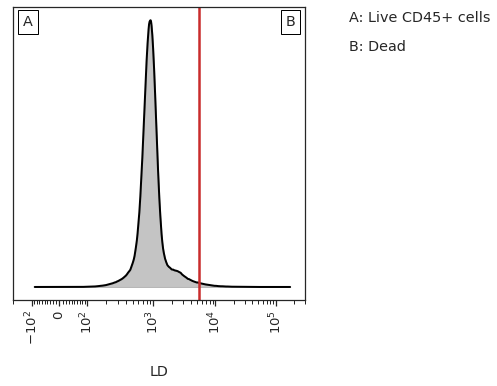

In [52]:
live_gate.label_children({"+": "Dead", "-": "Live CD45+ cells"})
gates.apply_gate(live_gate)

<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

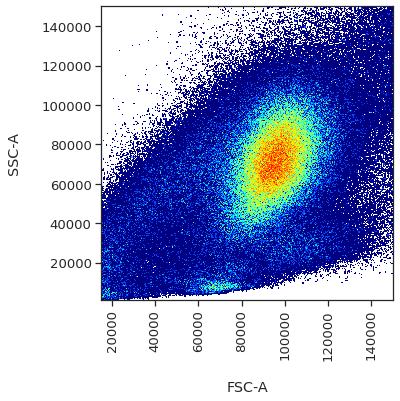

In [53]:
gates.plot_population("Live CD45+ cells", "FSC-A", "SSC-A", transform_x=None, transform_y=None)

In [54]:
gates.save()

<h2>Apply to experiment material</h2>

In [55]:
gates.apply_to_experiment(exp, 
                          logging_path="cd45_gatting.log")

  0%|          | 0/47 [00:00<?, ?it/s]